# Tarea 2 - Introducción a las Redes Neuronales y Deep Learning

**Nombre:** Bruno Morici

**ROL USM:** 202373555-8

**Curso:** INF395, Introducción a las Redes Neuronales y Deep Learning

**Profesor:** Alejandro Veloz

**Fecha:** 21/10/2025

# Parte 1: Desbalance de clases

### Pasos:
- Se hará uso de un dataset de clasificación de imágenes
- Artificialmente se limitarán las muestras de una clase para generar un desbalance artificial
- Se creará y entrenará un modelo FANN con las muestras totales
- Luego se harán predicciones midiendo el Acuraccy y el F1-Score (sobre todo en la clase desbalanceada, donde se espera sea cercano a cero)
- Luego se aplicará el método de Data Augmentation, para tomar las pocas muestras de la clase desbalanceada y balancearla a la par de las otras
- Finalmente se reentrenará el modelo, realizando nuevas predicciones y mediciones, para ver el efecto del método de rebalanceamiento.

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report
from collections import Counter

In [36]:
# Carga del dataset, creamos conjuntos de entrenamiento y prueba
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalización de los datos
train_images = train_images / 255.0
test_images = test_images / 255.0

# Definimos los nombres de las clases
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [37]:
minority_class = 4  # Desbalanceamos la clase "Coat"

minority_idx = np.where(train_labels == minority_class)[0]
majority_idx = np.where(train_labels != minority_class)[0]

np.random.seed(42)
minority_idx_reduced = np.random.choice(minority_idx, 100, replace=False)

new_train_idx = np.concatenate([minority_idx_reduced, majority_idx])
train_images_ds = train_images[new_train_idx] # Nuevo dataset de entrenamiento desbalanceado
train_labels_ds = train_labels[new_train_idx] # Nuevas etiquetas de entrenamiento desbalanceadas

print("Cantidad de imágenes desbalanceadas por clase:")
for i in range(10):
    print(f"{class_names[i]}: {(train_labels_ds==i).sum()}")



Cantidad de imágenes desbalanceadas por clase:
T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 100
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


In [38]:
# Creamos el modelo de arquitectura estándar con capas de neuronas mediante Keras
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

### 1.1 - Modelo desbalanceado
Modelo con solo 100 muestras de la clase "Coat"

In [39]:
# Fiteamos el modelo con el dataset desbalanceado
model_ds = create_model()
model_ds.fit(train_images_ds, train_labels_ds, epochs=10, verbose=2)

# Evaluamos el modelo desbalanceado
prob_model_ds = tf.keras.Sequential([model_ds, tf.keras.layers.Softmax()])
predictions_ds = np.argmax(prob_model_ds.predict(test_images), axis=1)

# Métricas para la clase desbalanceada "Coat"
mask = test_labels == minority_class
acc_ds = accuracy_score(test_labels[mask], predictions_ds[mask])
f1_ds = f1_score(test_labels[mask], predictions_ds[mask], average='macro')

# Resultados
print(f"Desbalanceado - Accuracy Coat: {acc_ds:.4f}, F1 Coat: {f1_ds:.4f}")


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1691/1691 - 4s - 3ms/step - accuracy: 0.8573 - loss: 0.4219
Epoch 2/10
1691/1691 - 5s - 3ms/step - accuracy: 0.8916 - loss: 0.3070
Epoch 3/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9019 - loss: 0.2716
Epoch 4/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9099 - loss: 0.2492
Epoch 5/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9147 - loss: 0.2328
Epoch 6/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9195 - loss: 0.2197
Epoch 7/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9221 - loss: 0.2087
Epoch 8/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9271 - loss: 0.1983
Epoch 9/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9291 - loss: 0.1901
Epoch 10/10
1691/1691 - 3s - 2ms/step - accuracy: 0.9317 - loss: 0.1834
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Desbalanceado - Accuracy Coat: 0.0810, F1 Coat: 0.0214


Ejemplo de predicción para el Modelo Desbalanceado

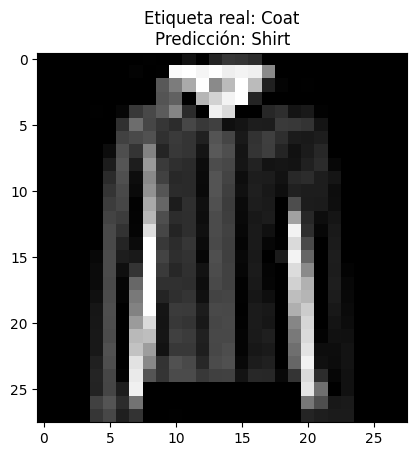

In [40]:
idx = np.where(test_labels==minority_class)[0][0]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_ds[idx]]}")
plt.show()

### 1.2 - Balanceo Artificial por remuestreo
- Modelo generado mediante un balanceo artificial de la clase "Coat"
- Se generaron rotaciones y modificaciones de altura y largo para modificar las muestras existentes y generar más.
- Se utiliza la técnica de remuestreo, mas puntualmente la de oversampling.

Balanceo por técnica de remuestreo oversampling

In [41]:
# Aumentación de datos para balancear la clase minoritaria
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

# Extraemos las imágenes y etiquetas de la clase minoritaria
minority_imgs = train_images_ds[train_labels_ds==minority_class]
minority_lbls = train_labels_ds[train_labels_ds==minority_class]

# Queremos igualar la cantidad de la clase minoritaria con la mayoría
majority_count = max([(train_labels_ds==i).sum() for i in range(10) if i!=minority_class])
n_needed = majority_count - len(minority_imgs)

aug_images, aug_labels = [], []

# Generamos imágenes aumentadas hasta alcanzar el balance
for x, y in zip(minority_imgs, minority_lbls):
    x = x.reshape((1,28,28,1))
    for batch in datagen.flow(x, batch_size=1):
        # Guardamos la imagen aumentada y su etiqueta
        aug_images.append(batch[0].reshape(28,28))
        aug_labels.append(y)
        if len(aug_images) >= n_needed:
            break
    if len(aug_images) >= n_needed:
        break

# Combinamos las imágenes aumentadas con el dataset desbalanceado
train_images_aug = np.concatenate([train_images_ds, np.array(aug_images)])
train_labels_aug = np.concatenate([train_labels_ds, np.array(aug_labels)])

print("Cantidad de imágenes después de balanceo artificial:")
for i in range(10):
    print(f"{class_names[i]}: {(train_labels_aug==i).sum()}")


Cantidad de imágenes después de balanceo artificial:
T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


Creamos el modelo balanceado artificialmente

In [42]:
# Fiteamos el modelo con el dataset balanceado artificialmente
model_aug = create_model()
model_aug.fit(train_images_aug, train_labels_aug, epochs=10, verbose=2)

# Evaluamos el modelo balanceado artificialmente
prob_model_aug = tf.keras.Sequential([model_aug, tf.keras.layers.Softmax()])
predictions_aug = np.argmax(prob_model_aug.predict(test_images), axis=1)

# Métricas para la clase desbalanceada "Coat"
acc_aug = accuracy_score(test_labels[mask], predictions_aug[mask])
f1_aug = f1_score(test_labels[mask], predictions_aug[mask], average='macro')

# Resultados
print(f"Balanceado artificial - Accuracy Coat: {acc_aug:.4f}, F1 Coat: {f1_aug:.4f}")


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 - 5s - 3ms/step - accuracy: 0.8695 - loss: 0.3914
Epoch 2/10
1875/1875 - 5s - 2ms/step - accuracy: 0.9019 - loss: 0.2807
Epoch 3/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9099 - loss: 0.2496
Epoch 4/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9182 - loss: 0.2259
Epoch 5/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9216 - loss: 0.2119
Epoch 6/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9269 - loss: 0.2008
Epoch 7/10
1875/1875 - 5s - 2ms/step - accuracy: 0.9287 - loss: 0.1915
Epoch 8/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9327 - loss: 0.1794
Epoch 9/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9359 - loss: 0.1730
Epoch 10/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9385 - loss: 0.1642
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Balanceado artificial - Accuracy Coat: 0.2710, F1 Coat: 0.0711


Ejemplo de predicción con el Modelo Artificialmente Balanceado

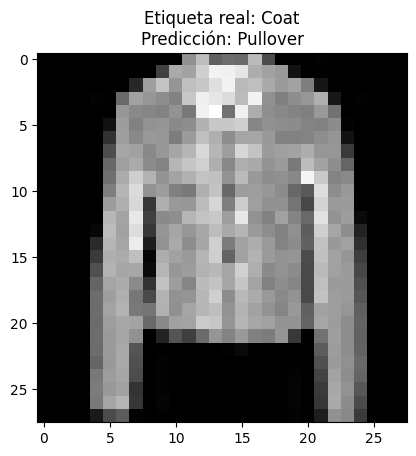

In [43]:
idx = np.where(test_labels==minority_class)[0][1]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_aug[idx]]}")
plt.show()

### 1.3 - Balanceo mediante modificación de la función objetivo
- Modelo generado mediante un balanceo artificial de la clase "Coat"
- Se penaliza más el error para la clase que posee menos muestras, en este caso "Coat".
- De esta forma el modelo compensa ese desbalance.
- No cambia el dataset, sino cómo el modelo aprende.

In [44]:
class_counts = Counter(train_labels_ds)
total_samples = len(train_labels_ds)
n_classes = len(class_counts)

# Si hay menos muestras de una clase, mayor será su peso
class_weight = {i: total_samples / (n_classes * class_counts[i]) for i in class_counts}

# Mostramos los pesos asignados por clase
print("Pesos asignados por clase:")
for i in range(10):
    print(f"{class_names[i]}: {class_weight[i]:.3f}")

Pesos asignados por clase:
T-shirt/top: 0.902
Trouser: 0.902
Pullover: 0.902
Dress: 0.902
Coat: 54.100
Sandal: 0.902
Shirt: 0.902
Sneaker: 0.902
Bag: 0.902
Ankle boot: 0.902


In [45]:
# Fiteamos el modelo con class_weight
model_weighted = create_model()
history_weighted = model_weighted.fit(train_images_ds, train_labels_ds,
                                      epochs=10, batch_size=64, verbose=0,
                                      validation_split=0.2,
                                      class_weight=class_weight)

# Evaluamos el modelo con class_weight
y_pred_w = np.argmax(model_weighted.predict(test_images), axis=1)
report_w = classification_report(test_labels, y_pred_w, output_dict=True)

mask = test_labels == minority_class
acc_wgt = accuracy_score(test_labels[mask], y_pred_w[mask])
f1_wgt = f1_score(test_labels[mask], y_pred_w[mask], average='macro')

# Resultados
print("\n--- Métricas para clase 'Coat' (con class_weight) ---")
print(f"Accuracy (Coat): {acc_wgt:.4f}")
print(f"F1-score (Coat): {f1_wgt:.4f}")

c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step

--- Métricas para clase 'Coat' (con class_weight) ---
Accuracy (Coat): 0.6610
F1-score (Coat): 0.1137


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


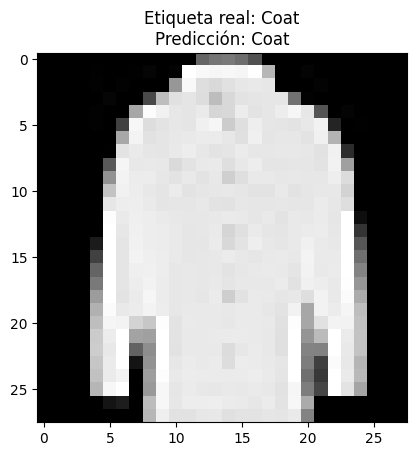

In [46]:
idx = np.where(test_labels == minority_class)[0][2]

plt.imshow(test_images[idx], cmap='gray')
pred_label = np.argmax(model_weighted.predict(np.expand_dims(test_images[idx], 0)))
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[pred_label]}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


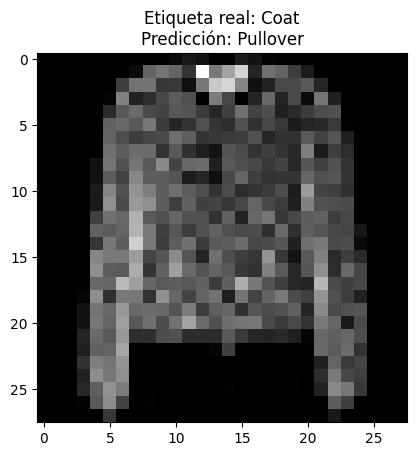

In [47]:
idx = np.where(test_labels == minority_class)[0][6]

plt.imshow(test_images[idx], cmap='gray')
pred_label = np.argmax(model_weighted.predict(np.expand_dims(test_images[idx], 0)))
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[pred_label]}")
plt.show()

### 1.4 - Modelo balanceado original
Dataset completo, sin crear recortes artificiales, éste se encuentra balanceado desde el inicio

In [48]:
model_bal = create_model()
model_bal.fit(train_images, train_labels, epochs=10, verbose=2)

prob_model_bal = tf.keras.Sequential([model_bal, tf.keras.layers.Softmax()])
predictions_bal = np.argmax(prob_model_bal.predict(test_images), axis=1)

acc_bal = accuracy_score(test_labels[mask], predictions_bal[mask])
f1_bal = f1_score(test_labels[mask], predictions_bal[mask], average='macro')
print(f"Balanceado original - Accuracy Coat: {acc_bal:.4f}, F1 Coat: {f1_bal:.4f}")



Epoch 1/10


c:\Users\Bruno\Desktop\INF395 - IRN\tareas\tarea_2\tf_venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 - 4s - 2ms/step - accuracy: 0.8245 - loss: 0.4967
Epoch 2/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8630 - loss: 0.3776
Epoch 3/10
1875/1875 - 3s - 2ms/step - accuracy: 0.8760 - loss: 0.3392
Epoch 4/10
1875/1875 - 3s - 2ms/step - accuracy: 0.8842 - loss: 0.3142
Epoch 5/10
1875/1875 - 3s - 2ms/step - accuracy: 0.8918 - loss: 0.2937
Epoch 6/10
1875/1875 - 4s - 2ms/step - accuracy: 0.8961 - loss: 0.2815
Epoch 7/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9000 - loss: 0.2685
Epoch 8/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9040 - loss: 0.2571
Epoch 9/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9078 - loss: 0.2473
Epoch 10/10
1875/1875 - 4s - 2ms/step - accuracy: 0.9110 - loss: 0.2399
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Balanceado original - Accuracy Coat: 0.7780, F1 Coat: 0.1750


Ejemplo de predicción con el Modelo Balanceado Original

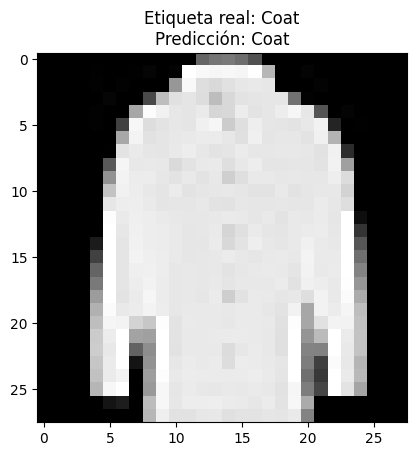

In [49]:
idx = np.where(test_labels==minority_class)[0][2]
plt.imshow(test_images[idx], cmap='gray')
plt.title(f"Etiqueta real: {class_names[test_labels[idx]]}\nPredicción: {class_names[predictions_bal[idx]]}")
plt.show()

### 1.5 - Comparación final de los 4 modelos

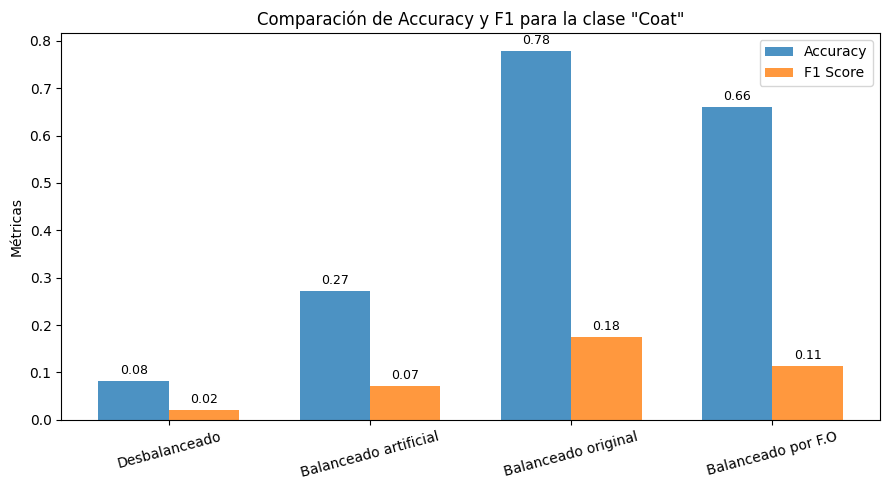

In [ ]:
# Nombres de los modelos
models = [
    'Desbalanceado',
    'Balanceado por Remuestreo',
    'Balanceado original',
    'Balanceado por F.O'
]

# Métricas obtenidas (rellena con tus valores reales)
acc_values = [acc_ds, acc_aug, acc_bal, acc_wgt]
f1_values = [f1_ds, f1_aug, f1_bal, f1_wgt]

# Configuración de posiciones y ancho de barras
x = np.arange(len(models))
width = 0.35

# Crear figura
fig, ax = plt.subplots(figsize=(9,5))
rects1 = ax.bar(x - width/2, acc_values, width, label='Accuracy', alpha=0.8)
rects2 = ax.bar(x + width/2, f1_values, width, label='F1 Score', alpha=0.8)

# Etiquetas y título
ax.set_ylabel('Métricas')
ax.set_title('Comparación de Accuracy y F1 para la clase "Coat"')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# Mostrar valores encima de cada barra
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

plt.tight_layout()
plt.show()

# Parte 2: Sistema de recomendación

### Parte 2.1: Reproducir ejemplo en PyTorch

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from zipfile import ZipFile
from urllib.request import urlretrieve

import pandas as pd

from sklearn.model_selection import train_test_split

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not os.path.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not os.path.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

In [45]:
raw_ratings = pd.read_csv(os.path.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Text(0, 0.5, 'Number of users')

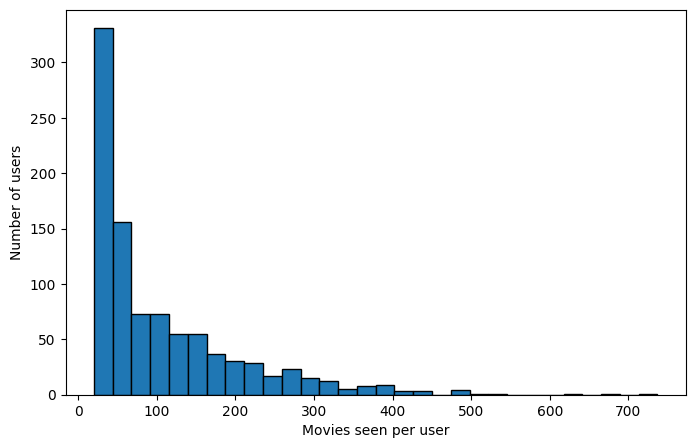

In [46]:
# Cuantas peliculas ha visto cada usuario
user_movie_counts = raw_ratings.groupby('user_id')['item_id'].nunique()

plt.figure(figsize=(8, 5))
plt.hist(user_movie_counts, bins=30, edgecolor='black')
plt.xlabel('Movies seen per user')
plt.ylabel('Number of users')

El archivo de metadatos contiene información como el nombre de la película o la fecha en que fue estrenada.

In [47]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(os.path.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


array([[<Axes: title={'center': 'release_year'}>]], dtype=object)

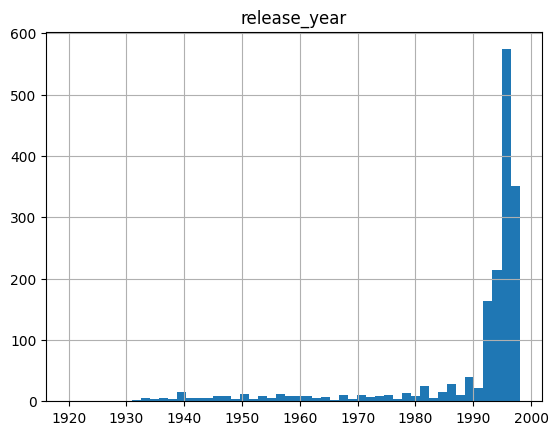

In [48]:
# Extraemos el año de lanzamiento de la película

def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50)

Complemento de los datos originales con los metadatos. Ahora existe duplicidad en los títulos, ya que se repite el dato del título para cada "rating"

In [49]:
all_ratings = pd.merge(items, raw_ratings)
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


In [50]:
# Estadisticas sobre todos los ratings
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Se calcula la popularidad de cada película en función de la cantidad de ratings que ha recibido. Luego, se combinan estos datos con la información de las películas para identificar las 10 películas más populares.

In [51]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)
items.nlargest(10, 'popularity')

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


In [52]:
items["title"][49]

'Star Wars (1977)'

In [53]:
indexed_items = items.set_index('item_id')
indexed_items["title"][50]

'Star Wars (1977)'

In [54]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,0.0,100000.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,NaN,1987.950100,462.48475,3.529860,8.835289e+08
std,330.798356,121.784558,NaN,14.169558,266.61442,1.125674,5.343856e+06
min,1.000000,1.000000,NaN,1920.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,NaN,1998.000000,943.00000,5.000000,8.932866e+08


In [55]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


#### Creamos el modelo de retroalimentación explítica: Predicción de calificaciones supervisada con PyTorch
Para cada par de (usuario, ítem) se intenta predecir la calificación que el usuario daría al ítem.

In [56]:
from sklearn import model_selection, preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import sys

# Seleccionar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cpu


Definimos el dataset personalizado que utilizara PyTorch para entregar usuarios, peliculas y ratings al modelo

In [57]:
# Dataset personalizado para PyTorch

class MovieLensDataset(Dataset):
    """
    Dataset MovieLens para entrenamiento y validacion
    """

    # Constructor del dataset, recibe listas de usuarios, peliculas y ratings
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    # Devuelve el tamano del dataset
    def __len__(self):
        return len(self.users)

    # Devuelve un solo elemento del dataset segun el indice dado
    def __getitem__(self, idx):
        return {
            "users": torch.tensor(self.users[idx], dtype=torch.long),   # id del usuario convertido a tensor
            "movies": torch.tensor(self.movies[idx], dtype=torch.long), # id de la pelicula convertido a tensor
            "ratings": torch.tensor(self.ratings[idx], dtype=torch.float) # rating dado por el usuario
        }



Definimos el modelo de recomendacion basado en embeddings y una red neuronal

In [58]:
class RecommendationSystemModel(nn.Module):
    # Constructor del modelo
    def __init__(self, num_users, num_movies, embedding_size=64, hidden_dim=128, dropout_rate=0.1):
        super(RecommendationSystemModel, self).__init__()

        # Capas de embedding para usuarios y peliculas
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # Capas densas para combinar embeddings
        self.fc1 = nn.Linear(2 * embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    # Forward define como fluye la informacion dentro del modelo
    def forward(self, users, movies):
        # Obtenemos los vectores embedding
        user_emb = self.user_embedding(users)
        movie_emb = self.movie_embedding(movies)

        # Concatenamos embeddings de usuario y pelicula
        x = torch.cat([user_emb, movie_emb], dim=1)

        # Pasamos por capa oculta y dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        # Capa final que predice el rating
        out = self.fc2(x)

        return out


Dividimos los datos en entrenamiento y prueba, y creamos datasets de PyTorch

In [59]:
# Dividimos el dataset
ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

# Extraemos columnas como numpy arrays
user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Creamos los datasets para PyTorch
train_dataset = MovieLensDataset(
    users=user_id_train,
    movies=item_id_train,
    ratings=rating_train,
)

valid_dataset = MovieLensDataset(
    users=user_id_test,
    movies=item_id_test,
    ratings=rating_test,
)

Creamos DataLoaders para cargar datos por lotes durante el entrenamiento

In [60]:
BATCH_SIZE = 512

# DataLoader para entrenamiento, mezcla los datos en cada epoch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# DataLoader para validacion
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Creamos el modelo, definimos optimizador y funcion de perdida

In [61]:
# Creamos el modelo
recommendation_model = RecommendationSystemModel(
    num_users=(len(user_id_test) + len(user_id_train)),  # total de usuarios
    num_movies=(len(item_id_test) + len(item_id_train)), # total de peliculas
    embedding_size=64,
    hidden_dim=128,
    dropout_rate=0.1,
).to(device)

# Optimizador Adam
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)

# Funcion de perdida MSE (regresion)
loss_func = nn.MSELoss()


Funcion auxiliar para mostrar el progreso del entrenamiento en consola

In [62]:
EPOCHS = 2

# Funcion para mostrar progreso en consola
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch+1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)

Entrenamiento del modelo por epocas registrando la perdida promedio

In [63]:
total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Entrenamiento en {train_dataset_size} muestras...")

recommendation_model.train()  # ponemos el modelo en modo entrenamiento

for e in range(EPOCHS):
    step_count = 0
    for i, train_data in enumerate(train_loader):
        # Pasamos datos al modelo
        output = recommendation_model(
            train_data["users"].to(device), train_data["movies"].to(device)
        )

        # Ajustamos dimensiones para compararlo con ratings
        output = output.squeeze()
        ratings = train_data["ratings"].to(torch.float32).to(device)

        # Calculamos perdida
        loss = loss_func(output, ratings)
        total_loss += loss.sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_count += len(train_data["users"])

        # Log cada cierto numero de pasos
        if (step_count % log_progress_step == 0 or i == len(train_loader) - 1):
            log_progress(
                e, step_count, total_loss, log_progress_step, train_dataset_size, losses
            )
            total_loss = 0



Entrenamiento en 80000 muestras...


02/02 | Step: 80000/80000 | Avg Loss: 0.076083362

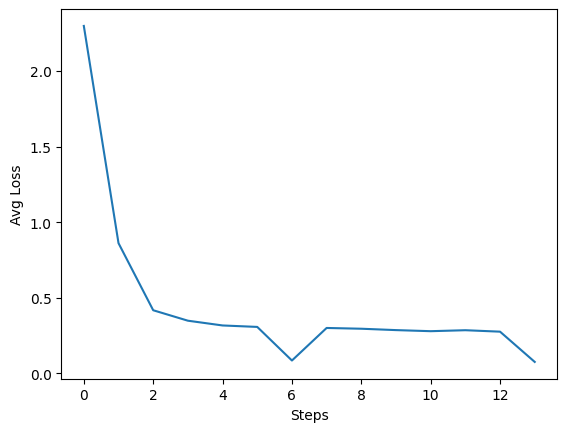

In [64]:
plt.figure()
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Avg Loss")
plt.show()

Evaluacion del modelo con RMSE usando el set de validacion

In [65]:
from sklearn.metrics import mean_squared_error

y_pred = []
y_true = []

recommendation_model.eval()  # cambiamos a modo evaluacion

with torch.no_grad():
    for i, valid_data in enumerate(val_loader):
        output = recommendation_model(
            valid_data["users"].to(device), valid_data["movies"].to(device)
        )
        ratings = valid_data["ratings"].to(device)
        y_pred.extend(output.cpu().numpy())
        y_true.extend(ratings.cpu().numpy())

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

RMSE: 1.0263


Funcion para calcular precision y recall por usuario

In [66]:
from collections import defaultdict

def calculate_precision_recall(user_ratings, k, threshold):
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    n_rel_and_rec_k = sum(
        (true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k]
    )

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall

user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall

Calculamos precision@k y recall@k promedios del modelo

In [67]:
average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 50: 0.8614
recall @ 50: 0.8829


Graficamos predicciones vs valores reales (Test Set)

Final Test MSE: 1.053
Final Test RMSE: 1.026
Final Test MAE: 0.825


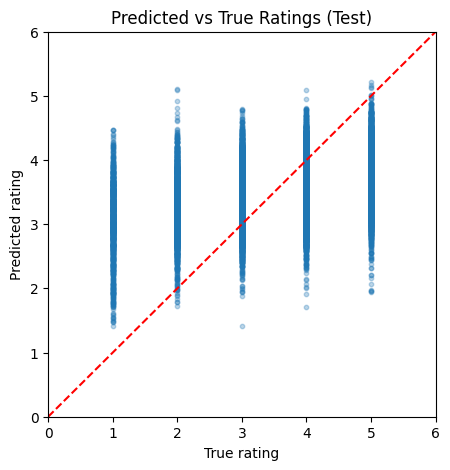

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

recommendation_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for batch in val_loader:
        users = batch["users"].to(device)
        movies = batch["movies"].to(device)
        ratings = batch["ratings"].to(device)
        outputs = recommendation_model(users, movies).squeeze()
        y_true.extend(ratings.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Final Test MSE: {mse:.3f}")
print(f"Final Test RMSE: {rmse:.3f}")
print(f"Final Test MAE: {mae:.3f}")

def plot_predictions(y_true, y_pred, title="Predicted vs True Ratings (Test)"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=10, alpha=0.3)
    plt.xlabel("True rating")
    plt.ylabel("Predicted rating")
    plt.title(title)
    plt.xlim(0, 6)
    plt.ylim(0, 6)
    plt.plot([0, 6], [0, 6], "r--")
    plt.show()

plot_predictions(y_true, y_pred)


Graficamos predicciones vs reales del conjunto de entrenamiento

Final Train MSE: 1.018
Final Train RMSE: 1.009
Final Train MAE: 0.811


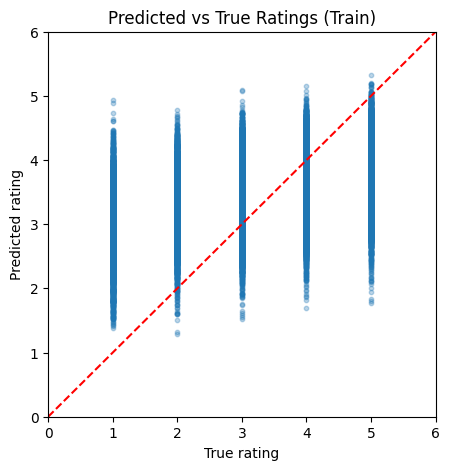

In [69]:
y_true_train = []
y_pred_train = []

recommendation_model.eval()
with torch.no_grad():
    for batch in train_loader:
        users = batch["users"].to(device)
        movies = batch["movies"].to(device)
        ratings = batch["ratings"].to(device)
        outputs = recommendation_model(users, movies).squeeze()
        y_true_train.extend(ratings.cpu().numpy())
        y_pred_train.extend(outputs.cpu().numpy())

mse_train = mean_squared_error(y_true_train, y_pred_train)
mae_train = mean_absolute_error(y_true_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

print(f"Final Train MSE: {mse_train:.3f}")
print(f"Final Train RMSE: {rmse_train:.3f}")
print(f"Final Train MAE: {mae_train:.3f}")

plot_predictions(y_true_train, y_pred_train, "Predicted vs True Ratings (Train)")

Ejemplo de prediccion con el modelo y explicacion de su interpretacion

In [70]:
### Ejemplo de prediccion para un usuario tomado del conjunto de test

# Tomamos el primer dato del dataset de validacion
sample_user = user_id_test[0]
sample_movie = item_id_test[0]
real_rating = rating_test[0]

# Convertimos a tensores y movemos al device
sample_user_tensor = torch.tensor([sample_user], dtype=torch.long).to(device)
sample_movie_tensor = torch.tensor([sample_movie], dtype=torch.long).to(device)

# Prediccion del modelo
recommendation_model.eval()
with torch.no_grad():
    predicted_rating = recommendation_model(sample_user_tensor, sample_movie_tensor).item()

print(f"Usuario: {sample_user}")
print(f"Pelicula: {sample_movie}")
print(f"Rating real: {real_rating:.2f}")
print(f"Rating predicho por el modelo: {predicted_rating:.2f}")

Usuario: 330
Pelicula: 22
Rating real: 5.00
Rating predicho por el modelo: 4.42


### Parte 2.2: Transformarlo en un problema de clasificación

* Antes el problema era una Regresión, entregando un número entre 1 y 5 correspondiente a la calificación del usuario.
* Pero ahora se tratará como un modelo de clasificación, donde las clases serán categorizadas con la función Softmax entregando una clase de las siguientes; {1,2,3,4,5}.

Conversión del dataset de regresión a clasificación (ratings → clases 0–4)

In [71]:
### Convertimos las calificaciones reales (1–5) en clases enteras (0–4)
# Esto es necesario porque la red usara Softmax no regresion

# Funcion para convertir rating a clase
def rating_to_class(ratings):
    return (ratings - 1).astype(int)

# Aplicamos la transformacion a los datos de entrenamiento
y_train_class = rating_to_class(rating_train)
y_test_class = rating_to_class(rating_test)

# Comprobamos visualmente la conversion
print("Ejemplo antes:", rating_train[:10])
print("Ejemplo después:", y_train_class[:10])

Ejemplo antes: [4 4 4 3 5 4 5 4 2 3]
Ejemplo después: [3 3 3 2 4 3 4 3 1 2]


Modelo modificado para clasificación Softmax, solo realizamos cambios en la capa final

In [72]:
class RecommendationSystemClassifier(nn.Module):
    # Constructor
    def __init__(self, num_users, num_movies, embedding_size=64, hidden_dim=128, dropout_rate=0.1):
        super(RecommendationSystemClassifier, self).__init__()

        # Embeddings de usuarios y películas
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        # Capa oculta igual que antes
        self.fc1 = nn.Linear(2 * embedding_size, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

        # Nueva capa final
        self.output_layer = nn.Linear(hidden_dim, 5)

        # Softmax para clasificacion multiclase
        self.softmax = nn.Softmax(dim=1)

    def forward(self, users, movies):
        # Embeddings
        user_emb = self.user_embedding(users)
        movie_emb = self.movie_embedding(movies)

        # Concatenamos
        x = torch.cat([user_emb, movie_emb], dim=1)

        # Pasamos por la capa oculta
        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        # Capa final de 5 probabilidades
        logits = self.output_layer(x)

        # Softmax convierte logits a probabilidades
        probs = self.softmax(logits)

        return probs


Definición del optimizador y función de pérdida para clasificación

In [73]:
recommendation_model = RecommendationSystemClassifier(
    num_users=(len(user_id_test) + len(user_id_train)),
    num_movies=(len(item_id_test) + len(item_id_train)),
    embedding_size=128,
    hidden_dim=128,
    dropout_rate=0.1,
).to(device)

# Optimizador Adam
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)

# Nueva funcion de perdida debido a que ahora es problema de clasificacion
loss_func = nn.CrossEntropyLoss()

Etapa de entrenamiento por epocas usando CrossEntropyLoss

In [74]:
EPOCHS = 10
total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

print("Antes de convertir:")
print(np.min(rating_train), np.max(rating_train))

# Convertimos ratings 1-5 a clases 0-4
rating_train -= 1
rating_test -= 1

print("Rango global de rating_train:", np.min(rating_train), np.max(rating_train))
print("Rango global de rating_test :", np.min(rating_test), np.max(rating_test))

recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0
    for i, train_data in enumerate(train_loader):

        # Prediccion del modelo (probabilidades por clase)
        output = recommendation_model(
            train_data["users"].to(device),
            train_data["movies"].to(device)
        )

        # Ratings reales convertidos a enteros 0-4
        ratings = train_data["ratings"].long().to(device)

        # Calculo de perdida
        loss = loss_func(output, ratings)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_count += len(train_data["users"])

        if step_count % log_progress_step == 0 or i == len(train_loader) - 1:
            avg_loss = total_loss / log_progress_step
            print(f"Epoch {e+1}/{EPOCHS} - Step {step_count}/{train_dataset_size} - Loss {avg_loss:.4f}")
            total_loss = 0


Training on 80000 samples...
Antes de convertir:
1 5
Rango global de rating_train: 0 4
Rango global de rating_test : 0 4
Epoch 1/10 - Step 12800/80000 - Loss 0.3938
Epoch 1/10 - Step 25600/80000 - Loss 0.3837
Epoch 1/10 - Step 38400/80000 - Loss 0.3805
Epoch 1/10 - Step 51200/80000 - Loss 0.3787
Epoch 1/10 - Step 64000/80000 - Loss 0.3769
Epoch 1/10 - Step 76800/80000 - Loss 0.3755
Epoch 1/10 - Step 80000/80000 - Loss 0.1041
Epoch 2/10 - Step 12800/80000 - Loss 0.3706
Epoch 2/10 - Step 25600/80000 - Loss 0.3693
Epoch 2/10 - Step 38400/80000 - Loss 0.3692
Epoch 2/10 - Step 51200/80000 - Loss 0.3690
Epoch 2/10 - Step 64000/80000 - Loss 0.3682
Epoch 2/10 - Step 76800/80000 - Loss 0.3669
Epoch 2/10 - Step 80000/80000 - Loss 0.1031
Epoch 3/10 - Step 12800/80000 - Loss 0.3621
Epoch 3/10 - Step 25600/80000 - Loss 0.3634
Epoch 3/10 - Step 38400/80000 - Loss 0.3648
Epoch 3/10 - Step 51200/80000 - Loss 0.3633
Epoch 3/10 - Step 64000/80000 - Loss 0.3632
Epoch 3/10 - Step 76800/80000 - Loss 0.3612

Evaluación del modelo con Accuracy y F1-score

In [75]:
from sklearn.metrics import accuracy_score, f1_score

y_true = []
y_pred = []

recommendation_model.eval()
with torch.no_grad():
    for batch in val_loader:
        users = batch["users"].to(device)
        movies = batch["movies"].to(device)
        ratings = batch["ratings"].long().to(device)

        outputs = recommendation_model(users, movies) # [batch_size, 5]
        preds = torch.argmax(outputs, dim=1) # Elegimos la clase con mayor probabilidad

        y_true.extend(ratings.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.4234
F1 Score: 0.3938


Ejemplo de predicción individual formateado

In [76]:
import torch.nn.functional as F

# Seleccionamos un ejemplo del dataset de prueba
sample_idx = 10
sample_user = user_id_test[sample_idx]
sample_movie = item_id_test[sample_idx]
sample_true_rating = rating_test[sample_idx]  # esta ya esta en rango 0-4

# Convertimos a tensores
user_tensor = torch.tensor([sample_user], dtype=torch.long).to(device)
movie_tensor = torch.tensor([sample_movie], dtype=torch.long).to(device)

recommendation_model.eval()
with torch.no_grad():
    output = recommendation_model(user_tensor, movie_tensor)  # [1,5]
    probs = F.softmax(output, dim=1).cpu().numpy().flatten()
    pred_class = np.argmax(probs)

# Mostramos las probabilidades formateadas
print("\n=== Ejemplo de prediccion ===")
for i, p in enumerate(probs):
    print(f"Probabilidad clase {i} -> {p:.4f}")

print(f"\nPrediccion final -> Clase {pred_class}")
print(f"Rating real (target) -> Clase {sample_true_rating}")



=== Ejemplo de prediccion ===
Probabilidad clase 0 -> 0.1512
Probabilidad clase 1 -> 0.1512
Probabilidad clase 2 -> 0.1615
Probabilidad clase 3 -> 0.3848
Probabilidad clase 4 -> 0.1513

Prediccion final -> Clase 3
Rating real (target) -> Clase 2
